# Click On Ad Prediction

## 1. Business Problem

To identify the right customers who will click on our ad is one of the most important tasks in our marketing campaign. The users who click may be converted and retained thus bringing revenue to the business. However, identifying the wrong ones will bring loss through spending money on nothing. Therefore, the purpose of this project is to optimise the model that is able to predict who will click and to minimise the false positive rate in order to contribute to the success of the business.

## 2. Discover

### -- Import Libraries --

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, classification_report, roc_curve, confusion_matrix, fbeta_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### -- Load The Data --

In [3]:
advertising_df = pd.read_csv('advertising_dsdj.csv')
advertising_df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


### -- Clean The Data --

In [4]:
# Changing column names to lower case
new_name = advertising_df.columns.str.lower().values 
advertising_df.columns = new_name

In [5]:
# Check for length and dtypes
advertising_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   daily time spent on site  1018 non-null   float64
 1   age                       1018 non-null   int64  
 2   area income               1018 non-null   float64
 3   daily internet usage      1018 non-null   float64
 4   ad topic line             1018 non-null   object 
 5   city                      1018 non-null   object 
 6   male                      1018 non-null   int64  
 7   country                   1018 non-null   object 
 8   timestamp                 1018 non-null   object 
 9   clicked on ad             1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.7+ KB


In [6]:
# Checking for missing values
advertising_df.isnull().sum()

daily time spent on site    0
age                         0
area income                 0
daily internet usage        0
ad topic line               0
city                        0
male                        0
country                     0
timestamp                   0
clicked on ad               4
dtype: int64

In [7]:
# Dropping observations that have missing values on the target variable
advertising_df.dropna(axis = 0, inplace=True)

In [8]:
# Checking for duplicated entries
advertising_df[advertising_df.duplicated()]

,daily time spent on site,age,area income,daily internet usage,ad topic line,city,male,country,timestamp,clicked on ad
162,75.55,36,73234.87,159.24,Managed grid-enabled standardization,Ramirezside,0,Liechtenstein,2016-05-09 2:58,1.0
222,53.30,34,44893.71,111.94,Self-enabling optimal initiative,West Jessicahaven,0,Mauritania,2016-05-06 21:07,1.0
235,84.08,30,62336.39,187.36,Face-to-face intermediate approach,Carterburgh,1,Fiji,2016-01-13 2:58,0.0
923,87.18,31,58287.86,193.60,Right-sized logistical middleware,West Andrew,0,Madagascar,2016-01-31 5:12,0.0
924,87.18,31,58287.86,193.60,Right-sized logistical middleware,West Andrew,0,Madagascar,2016-01-31 5:12,0.0
925,87.18,31,58287.86,193.60,Right-sized logistical middleware,West Andrew,0,Madagascar,2016-01-31 5:12,0.0
944,72.55,22,58953.01,202.34,Balanced empowering success,New Cynthia,0,Bosnia and Herzegovina,2016-02-08 7:33,0.0


In [9]:
# Dropping 3 duplicated line with index 923, 924, 925
advertising_df.drop(index = [923,924,925], axis = 0, inplace = True)

In [10]:
# Convert 'timestamp' into datetime dtypes
advertising_df['timestamp'] = pd.to_datetime(advertising_df['timestamp'])

## 3. Exploratory Data Analysis

### -- Calculate Clicked On Ad Rate --

In [11]:
click_rate = advertising_df['clicked on ad'].value_counts(1)
click_rate

1.0    0.502473
0.0    0.497527
Name: clicked on ad, dtype: float64

### -- Statistical Overview --

In [12]:
advertising_df.describe()

,daily time spent on site,age,area income,daily internet usage,male,clicked on ad
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,64.977794,36.932740,54919.003600,179.330465,0.481701,0.502473
std,15.840008,31.671042,13450.575621,44.522130,0.499912,0.500241
min,32.600000,-25.000000,13996.500000,23.640000,0.000000,0.000000
25%,51.340000,29.000000,46899.780000,138.490000,0.000000,0.000000
50%,68.110000,35.000000,56986.730000,182.200000,0.000000,1.000000
75%,78.535000,42.000000,65350.775000,218.355000,1.000000,1.000000
max,91.430000,999.000000,79484.800000,269.960000,1.000000,1.000000


In [13]:
advertising_df.describe(include='object')

,ad topic line,city,country
count,1011,1011,1011
unique,1000,969,237
top,Re-engineered real-time success,Williamsport,France
freq,2,4,9


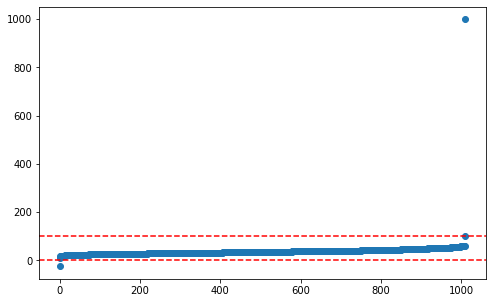

In [14]:
#plotting the age by scatter plot
fig = plt.figure(figsize=(8,5))
plt.scatter(x=np.arange(len(advertising_df['age'])), y = sorted(advertising_df['age']))
plt.axhline(y=0, linestyle='--', color='r')
plt.axhline(y=100, linestyle='--', color='r')

In [15]:
# Let's have a look at rows with age < 18 & age > 100
extreme = advertising_df[(advertising_df['age'] < 18) | (advertising_df['age'] > 100)]

In [16]:
# Let's drop these extreme age values
advertising_df.drop(axis = 0, index = extreme.index, inplace=True)

In [17]:
# Let's look at the 'daily time spent on site' & 'daily internet usage' 
# to filter out the rows that do not make sense
invalid_rows = advertising_df[advertising_df['daily time spent on site'] > advertising_df['daily internet usage']]
# Drop these invalid rows
advertising_df.drop(index=invalid_rows.index, axis = 0, inplace=True)

### -- Feature Distributions --

In [18]:
def dist_plot_features(df, feature, size):
    plt.figure(figsize=size)
    for i in range(len(feature)):
        plt.subplot(3,3,i+1)
        sns.distplot(df[feature[i]])

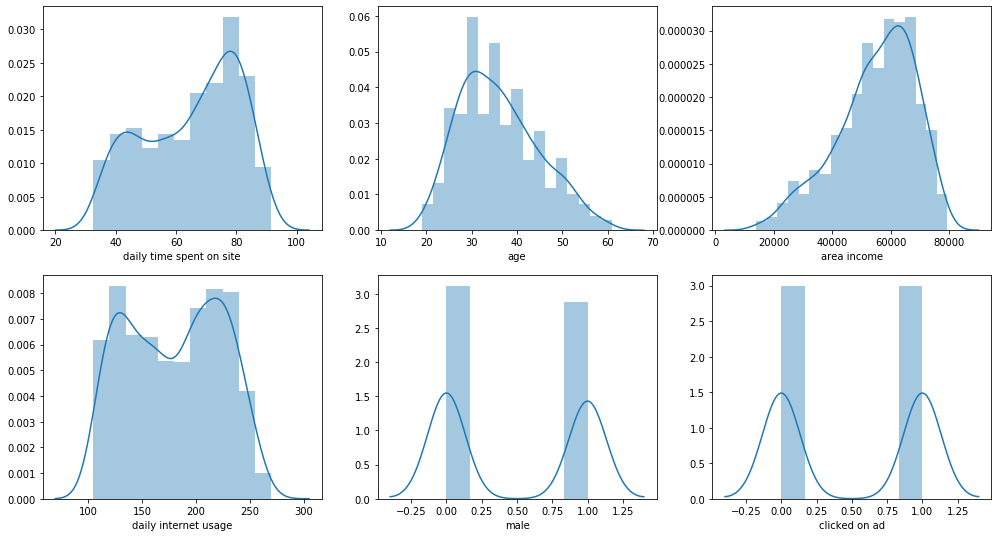

In [19]:
numerical_vars = advertising_df.select_dtypes(exclude=['object', 'datetime64']).columns
dist_plot_features(advertising_df, feature=numerical_vars, size = (17,14))

The 'daily time spent on site' and 'daily internet usage' follow the bimodal distribution. It means that they may have two distinct groups. The 'age' and 'area income' variables are slightly skewed which could reduce the accuracy of our model later on. We need to apply a transformation on these variables using the following steps.

### -- Boxplot --

In [20]:
def box_plot_features(df, features, target, size):
    plt.figure(figsize=size)
    for i in range(len(features)-1):
        plt.subplot(3,3,i+1)
        sns.boxplot(x=target, y = features[i], data=df)

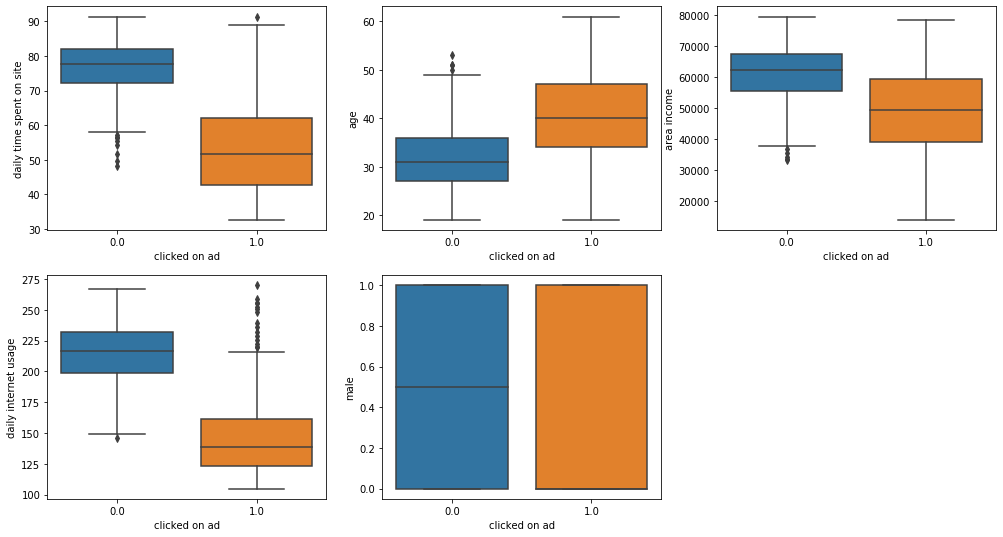

In [21]:
box_plot_features(advertising_df, features=numerical_vars, target = 'clicked on ad', size = (17,14))

From the box plots above, We could conclude that the 2 groups namely 'clicked on ad' and 'not clicked on ad', are very distinct in their internet habits, income and age. We will have a further look at these variables next. 

### -- Correlation --

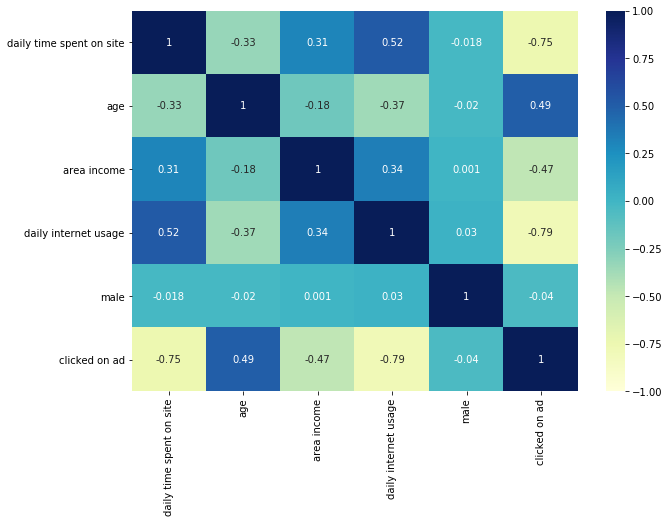

In [22]:
fig = plt.figure(figsize=(10,7))
sns.heatmap(advertising_df.corr(), annot=True, cmap= "YlGnBu", vmin = -1, vmax = 1)

We could see some interesting trends from our correlation heatmap. In terms of the relationship between our target variable and the features, 'daily time spent on site', 'daily internet usage' are negatively correlated with the target variable. Meanwhile, 'age' and 'clicked on ad' are positively correlated. For the relationship between features, 'daily internet usage' has the positive correlation with 'daily time spent on site'.

### -- Distribution Plots With Respect To Target Feature --

In [23]:
# Subsetting by clicks
click_yes = advertising_df['clicked on ad'] == 1
click_no = advertising_df['clicked on ad']==0

In [24]:
def distplot_features_target(df, features):
    plt.figure(figsize = (14,10))
    for feature in features:
        plt.subplot(2,2,features.index(feature) + 1)
        sns.distplot(df[feature][click_yes], label = 'click', color = 'cyan')
        sns.distplot(df[feature][click_no], label = 'no click', color = 'orange')
        plt.axvline(df[feature][click_yes].mean(), linestyle = '--', color = 'cyan')
        plt.axvline(df[feature][click_no].mean(), linestyle = '--', color = 'orange')
        plt.legend()

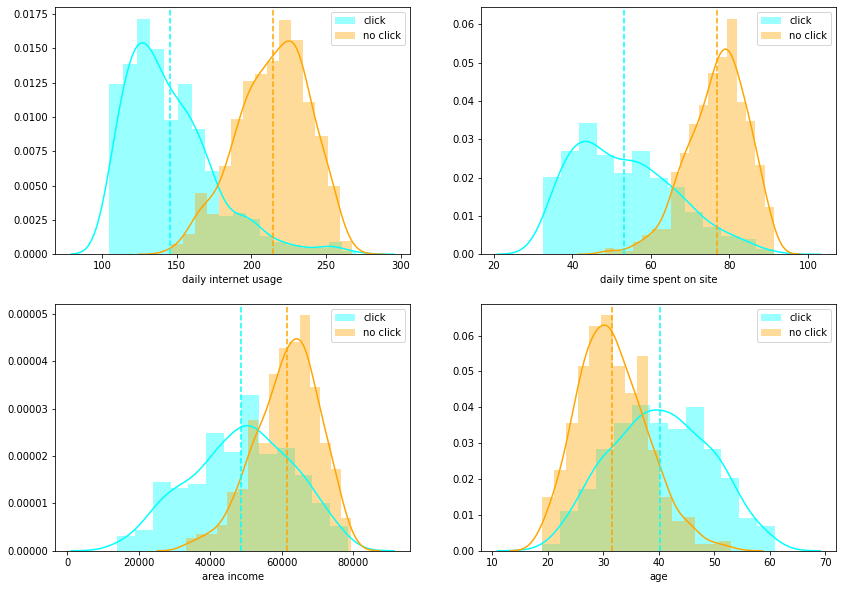

In [25]:
features = ['daily internet usage', 'daily time spent on site', 'area income', 'age']
distplot_features_target(advertising_df, features)

### -- Categorical Variables --

In [26]:
print('The number of unique cities in our advertising_df is: {}'.format(advertising_df['city'].nunique()))
print('The number of unique countries in our advertising_df is: {}'.format(advertising_df['country'].nunique()))
print('There are {} observations in our advertising_df'.format(len(advertising_df)))

The number of unique cities in our advertising_df is: 969
The number of unique countries in our advertising_df is: 237
There are 1004 observations in our advertising_df


The 'city' variable has too many unique values within our small dataset and as such it holds no strong predictive value in our model and thus will be ignored. Instead, we will look at the less diverse variable named 'country'  for our analysis to look for user patterns from each country.

In [27]:
count_country = pd.crosstab(index = advertising_df['country'], columns='count')
print(count_country.sort_values(['count'], ascending = False).head())
print(count_country.sort_values(['count'], ascending = False).tail())

col_0                   count
country                      
France                      9
Czech Republic              9
Afghanistan                 8
Bosnia and Herzegovina      8
Turkey                      8
col_0                                               count
country                                                  
Slovenia                                                1
Saint Kitts and Nevis                                   1
Romania                                                 1
British Indian Ocean Territory (Chagos Archipel...      1
Bermuda                                                 1


In [28]:
country_count_click = pd.crosstab(advertising_df['country'], advertising_df['clicked on ad'],
                                  rownames=['country'], colnames=['clicked on ad'])
print(country_count_click.sort_values(1, ascending = False).head())
print(country_count_click.sort_values(1, ascending = False).tail())

clicked on ad  0.0  1.0
country                
Australia        1    7
Turkey           1    7
Liechtenstein    0    7
Ethiopia         0    7
Liberia          2    6
clicked on ad  0.0  1.0
country                
Nicaragua        3    0
Niue             3    0
Panama           2    0
Reunion          2    0
Aruba            1    0


In [55]:
def print_summary(df, col, label):
    print('The maximum number of {} from countries accross the globe is: {}'.format(label, df[col].max()))
    print('The minimum number of {} from countries accross the globe is: {}'.format(label, df[col].min()))
    print('The average number of {} from countries accross the globe is: {}'.format(label, round(df[col].mean(),2)))
    print('The standard deviation of {} from countries accross the globe is: {}'.format(label, round(df[col].std(),2)))

In [56]:
print_summary(count_country, col = 'count', label = 'users')

The maximum number of users from countries accross the globe is: 9
The minimum number of users from countries accross the globe is: 1
The average number of users from countries accross the globe is: 4.24
The standard deviation of users from countries accross the globe is: 1.85


In [57]:
print_summary(country_count_click, col = 1, label = 'click users')

The maximum number of click users from countries accross the globe is: 7
The minimum number of click users from countries accross the globe is: 0
The average number of click users from countries accross the globe is: 2.12
The standard deviation of click users from countries accross the globe is: 1.43


## 4. Feature Engineering

### -- Log Transform On Skewed Features --

As being mentioned previously, we have skewed features namely 'age' and 'area income' and these could cause our model performing poorly. A recommended solution here is to perform a log transformation to reduce the effect of outliers and distribution's range.

In [32]:
advertising_df['log age'] = np.log(advertising_df['age'])

In [33]:
#advertising_df['log area income'] = np.log(advertising_df['area income'])

### -- Feature Removing --

As being mentioned above, We will remove 'city' due to its extreme diversity. For the time being and for the simplicity of our model, we will delete 'timestamp' and 'ad topic line' as these need special approaches like Natural Language Processing and Time Series Analysis. 

In [34]:
dropped_cols = ['city', 'timestamp', 'ad topic line', 'age']
advertising_df.drop(axis = 1, columns = dropped_cols, inplace = True)

### -- Numerical Feature Normalisation --

In [35]:
#Define variable
numerical_vars = ['daily time spent on site', 'daily internet usage', 'male',
                  'clicked on ad', 'log age','area income']
categorical_vars = 'country'
target = 'clicked on ad'
#make a copy of our data
copy_df = advertising_df.copy()

In [36]:
scaler = MinMaxScaler()
copy_df[numerical_vars] = scaler.fit_transform(copy_df[numerical_vars])

In [37]:
copy_df.head()

,daily time spent on site,area income,daily internet usage,male,country,clicked on ad,log age
0,0.617882,0.730472,0.916031,0.0,Tunisia,0.0,0.523740
1,0.809621,0.831375,0.538746,1.0,Nauru,0.0,0.419696
2,0.626721,0.699200,0.797433,0.0,San Marino,0.0,0.268903
3,0.706272,0.623160,0.854280,1.0,Italy,0.0,0.362521
4,0.608023,0.914568,0.731323,0.0,Iceland,0.0,0.523740


### -- One Hot - Encoding --

In [38]:
country = pd.get_dummies(advertising_df['country'], prefix='country', prefix_sep='_')

In [39]:
copy_df = copy_df.drop(axis = 1, columns=['country'])

In [40]:
new_advertising_df = pd.concat([copy_df, country], axis = 1)

## 5. Model Selection

As mentioned above, we will remove 'city' due to its extreme diversity. For the time being and for the simplicity of our model, we will delete 'timestamp' and 'ad topic line' as these need special approaches like Natural Language Processing and Time Series Analysis.  

We will test different algorithms including Logistic Regression and Random Forest Classifier. The best model will be chosen and tuned to find the best parameters to optimise performance. The metrics used for assessing our models are:
  - F1 score (F-beta)
  - Time

Logistic Regression will be chosen over its counterpart due to its simplicity and faster running time. Our goal is not just only to choose a model for its accuracy but also its fast running time. A grid Search CV will be performed to look for the best value of parameter 'C'.  

Our objective here is to minimise the false positive rate as low as possible as we do not want to have to spend money on the users who will not click. Minimising false positive rate means that we will have to maximise our precision. In this situation to gain the best result we will use the f-beta score which is the generalisation of F1-score, however, we could optimise it over the beta score. A beta score of 1 will generate the same result as F1, a score of 2 will give more weight to recall and a value of 0.5 will give more weight to precision which we wish to maximise.

### -- Train - Test - Split --

In [41]:
y = new_advertising_df.pop('clicked on ad') 

In [42]:
X = new_advertising_df

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [44]:
#double check on our train and test set
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(803, 242)
(803,)
(201, 242)
(201,)


### -- Logistic Regression --

### -- Model Tuning --

In [45]:
#apply Grid Search on our Logistic Regression model using F_score(F-beta) as a scoring method
model= LogisticRegression(random_state=40, penalty='l2')
params = {'C': [0.01, 0.1, 1, 2,3,4,5,6,7,8,9,10,20,50,100]}
scorer = make_scorer(fbeta_score, beta = 0.5)
grid_search_object = GridSearchCV(model, param_grid=params, scoring=scorer)
grid_search_object.fit(X_train, y_train)
best_estimator = grid_search_object.best_estimator_

In [46]:
#Create a function to make a prediction on data and print out a report 
def best_classification_report(X,y, data_name):
    best_prediction = best_estimator.predict(X)
    F_score = fbeta_score(y, best_prediction, beta = 0.5)
    print(best_estimator)
    print('\n F-score on {} : {:.4f}'.format(data_name, F_score))
    print('--- Optimised Summary ---')
    print('-- confusion_matrix --')
    conmat = confusion_matrix(y, best_prediction)
    print('The number of True Positives: {}'.format(conmat[1,1]))
    print('The number of False Positives: {}'.format(conmat[0,1]))
    print('The number of True Negatives: {}'.format(conmat[0,0]))
    print('The number of False Negatives: {}'.format(conmat[1,0]))
    print('-- classification report --')
    print(classification_report(y, best_prediction))

### -- Perform On Trainning Set --

In [47]:
best_classification_report(X = X_train, y= y_train, data_name='Train Data')

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 F-score on Train Data : 0.9785
--- Optimised Summary ---
-- confusion_matrix --
The number of True Positives: 373
The number of False Positives: 3
The number of True Negatives: 398
The number of False Negatives: 29
-- classification report --
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       401
         1.0       0.99      0.93      0.96       402

    accuracy                           0.96       803
   macro avg       0.96      0.96      0.96       803
weighted avg       0.96      0.96      0.96       803



In [48]:
#Let's make a change by moving threshold to the left
y_pred_prob = best_estimator.predict_proba(X_train)[:,1]

In [49]:
#Let's make a change by movinf threshold to the left
y_pred_prob_class = np.where(y_pred_prob < 0.45,0,1)
best_classification_report(X_train, y_pred_prob_class, 'Train Data')

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 F-score on Train Data : 0.9691
--- Optimised Summary ---
-- confusion_matrix --
The number of True Positives: 376
The number of False Positives: 0
The number of True Negatives: 367
The number of False Negatives: 60
-- classification report --
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       367
           1       1.00      0.86      0.93       436

    accuracy                           0.93       803
   macro avg       0.93      0.93      0.93       803
weighted avg       0.94      0.93      0.93       803



### -- Perform On Testing Set --

In [50]:
best_classification_report(X_test, y_test, 'Test Data')

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 F-score on Test Data : 0.9722
--- Optimised Summary ---
-- confusion_matrix --
The number of True Positives: 91
The number of False Positives: 1
The number of True Negatives: 100
The number of False Negatives: 9
-- classification report --
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       101
         1.0       0.99      0.91      0.95       100

    accuracy                           0.95       201
   macro avg       0.95      0.95      0.95       201
weighted avg       0.95      0.95      0.95       201



In [51]:
#Let's make a change by moving threshold to the left
y_pred_prob = best_estimator.predict_proba(X_test)[:,1]
y_pred_prob_class = np.where(y_pred_prob < 0.45,0,1)
best_classification_report(X_test, y_pred_prob_class, 'Test Data')

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 F-score on Test Data : 0.9623
--- Optimised Summary ---
-- confusion_matrix --
The number of True Positives: 92
The number of False Positives: 0
The number of True Negatives: 91
The number of False Negatives: 18
-- classification report --
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        91
           1       1.00      0.84      0.91       110

    accuracy                           0.91       201
   macro avg       0.92      0.92      0.91       201
weighted avg       0.93      0.91      0.91       201



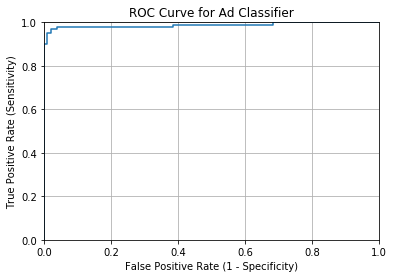

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC Curve for Ad Classifier")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(True)

From the Optimised Summary we could see our model performing very well on the test set. It generates a precision rate of 99% and an F-score of 97%. It performs even better when we move the threshold to the left allowing us to reach a precision rate of 100%. In the next step let's look at the feature importances of our model.

### -- Feature Importances --

In [53]:
def summarise_feature_importance(feature_names, model, summarise_cols, col_name):
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    key_list = []
    value_list = []
    for key, value in feature_dict.items():
        if key not in summarise_cols:
            key_list.append(key)
            value_list.append(value)
            sum_col = sum(value_list)
    feature_dict[col_name] = sum_col
    for k in key_list:
        feature_dict.pop(k)
    results = pd.Series(feature_dict, feature_dict.keys())
    results.sort_values(inplace=True)
    results.plot(kind = 'barh', figsize = (12,7))

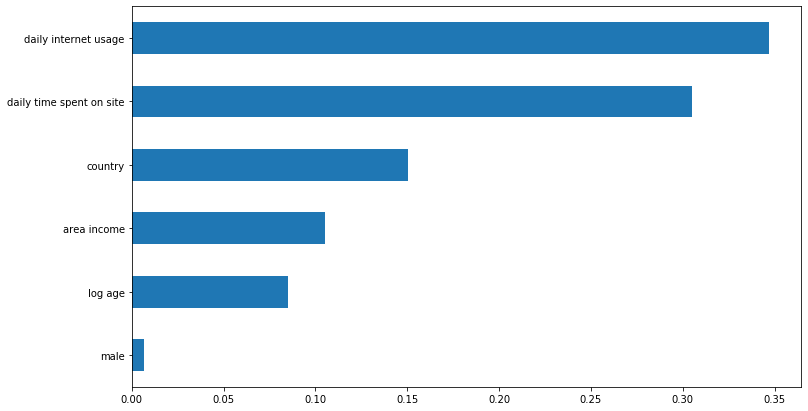

In [54]:
summarise_cols = ['daily time spent on site', 'area income', 'daily internet usage',
       'male', 'log age']
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
summarise_feature_importance(feature_names=X_train.columns,
                             model = rf_model, summarise_cols=summarise_cols, col_name='country')

## 6. Conclusion

According to our model feature importances we can target our customers from the following information:
- Daily internet usage
- Daily time spent on site
- Income
- Age

Our finding from the Exploratory Data Analysis suggests that our target customers would be users who:
- Spend less time on the internet
- Spend less time on our website
- Having lower income
- Older that our calculated average age of 40

Also by decreasing our threshold to 0.45 our model performs the best by generating the minimum false positive rate which optimises the business profit.